## initial code for our Hand Gesture Recognition

In [1]:
# ML models imports
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from skimage.feature import hog

# destribution models imports
from scipy.stats import randint, uniform

# Data manipulation imports
import numpy as np
import pandas as pd
import tqdm as tqdm

# visualisation models imports
import matplotlib.pyplot as plt

# image processing imports
import skimage.io as io
import cv2
from skimage.transform import resize

# dealing with files
import os

# visual dataset (to test randomized gridsearch not needed for now)
from sklearn.datasets import make_hastie_10_2  # to test our models

# from utils import prepareData, LoadData, FeatureExtraction, preprocess
import csv

In [2]:
def segment(image):
    blured_image = cv2.GaussianBlur(image, (7, 7), 0)
    ycbcr_image = cv2.cvtColor(blured_image, cv2.COLOR_BGR2YCrCb)
    # Extract the Cr channel
    cr_channel = ycbcr_image[:,:,1]

    # Apply thresholding to obtain a binary image
    _, binary_img = cv2.threshold(cr_channel,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Define the structuring element for the closing operation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))

    # Perform the closing operation
    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)

    # Find the contours in the binary image
    contours, hierarchy = cv2.findContours(closed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filling the contours on a copy of the original image
    img_contours = cv2.cvtColor(cr_channel, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(img_contours, contours, -1, (0, 0, 0), -1)
    gray = cv2.cvtColor(img_contours, cv2.COLOR_BGR2GRAY)

    return gray

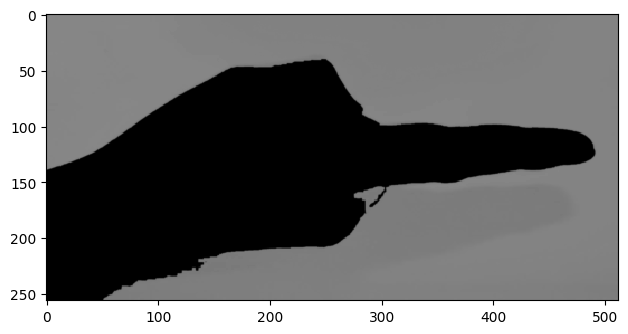

In [3]:
image = io.imread('1_men (1).JPG')
segmented = segment(image)
io.imshow(resize(segmented,(256,512))) 

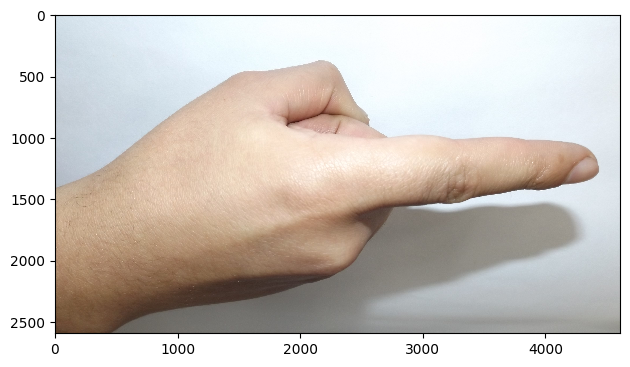

In [4]:
io.imshow(image)

In [5]:
segmented.shape

(2592, 4608)

In [15]:
from skimage.transform import resize
def FeatureExtraction(image):
    # this written code is an initial code for extracting features

    '''

        TODO: Feature Extraction code should be implemented here.  

    '''
    
    resized_image = resize(image,(1000,1000))   # downscaing from approx 2500x4000 to 500x500,500))   # downscaing from approx 2500x4000 to 500x500
    
    # Extract the hog features
    # block_norm uses L2 norm with hysterisis for reducing effect of illuminacity
    # transform_sqrt for applying gamma correction
    segmented = segment(image)

    resized_image = resize(segmented,(512,1024))

    hog_features = hog(resized_image, block_norm='L2-Hys', feature_vector=True, transform_sqrt=True)

    # image = np.array(resized).flatten() # flatten our image to be used as input vector to our model

    return hog_features

In [16]:
def LoadData():
    Features=[]
    labels=[]

    i = 0

    
    for gender in ["men","Women"]:
        datadir = r"Dataset\{}".format(gender)
        # loop over gender
        for hand in os.listdir(datadir): 
            # loop over each class [0,1,2,3,4,5]
            for img in os.listdir(datadir+ "/" +str(hand)):
                # ignoring anything except images
                if((img.split('.')[-1]).lower() not in ['jpg','png','jpeg']):
                    continue

                # loading our images
                img_array=io.imread(datadir + "/" + str(hand) + "/" + img )  # approx 2500 * 4000

                # append extracted features to Featurees list   
                Feature = FeatureExtraction(img_array)        
                Features.append(Feature) 

                # append class of image.
                labels.append(hand)  

                print(f'image Number: {i}')
                i+=1
                # # print(f'saving block : {i//100}')
                # # np.save(f'Features/{i}.npy', Feature)
                # # Features = []
                # # labels = []
                # with open("Features.csv", 'a') as csvfile:
                #     csvwriter = csv.writer(csvfile)
                #     csvwriter.writerow(Feature)

    return np.asarray(Features),np.asarray(labels)

In [ ]:
Features, labels = LoadData() 

In [20]:
labels

array(['0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '2', '2', '2',
       '2', '2', '3', '3', '3', '3', '3', '4', '4', '4', '4', '5', '5',
       '5', '5', '5', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1',
       '2', '2', '2', '2', '2', '3', '3', '3', '3', '3', '4', '4', '4',
       '4', '4', '5', '5', '5', '5', '5'], dtype='<U1')

In [5]:
# np.save('labels.npy', labels)
# np.save('features.npy', Features)
# labels=np.load('labels.npy')
# len(labels)

1821

In [6]:
# Use Pandas to read the CSV file in chunks of 1000 rows
chunk_size = 10
for chunk in pd.read_csv('Features.csv', chunksize=chunk_size):
    # Process each chunk of data here
    print(chunk.head())

In [24]:
test = np.load('Features/1.npy')
test.max()

0.9999999987499999

In [4]:
img = cv2.imread('1_men (2).JPG')
lower_rgb=np.array([0, 0, 0],dtype="uint8")
upper_rgb=np.array([230, 230, 230],dtype="uint8")
skin_region=cv2.inRange(img,lower_rgb,upper_rgb)
cv2.imwrite("segmented_2.jpg",skin_region)

True

* # Selecting the best model

- ### Define hyperparameter grids for each model

In [11]:
param_distributions = {
    'RandomForestClassifier': {
        'n_estimators': randint(50, 500),
        'max_depth': randint(2, 20),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'max_features': ['sqrt', 'log2']
    },
    'GradientBoostingClassifier': {
        'learning_rate': uniform(0.01, 0.2),
        'n_estimators': randint(50, 500),
        'max_depth': randint(2, 20),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'max_features': ['sqrt', 'log2']
    },
    'SVC': {
        'C': uniform(0.01, 10),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': randint(2, 5),
        'gamma': ['scale', 'auto'] + list(np.arange(0.1, 1, 0.1))
    },
    'LogisticRegression': {
        'C': uniform(0.01, 10),
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': randint(50, 500)
    },
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': randint(2, 20),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'max_features': ['sqrt', 'log2']
    },
    'KNeighborsClassifier': {
        'n_neighbors': randint(3, 30),
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'leaf_size': randint(10, 100)
    },
    'GaussianNB': {
        'var_smoothing': uniform(1e-09, 1e-07)
    },
    'MLPClassifier': {
        'hidden_layer_sizes': [(50, 50), (100,), (100, 50)],
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'alpha': uniform(0.0001, 0.01),
        'max_iter': randint(100, 1000)
    }
}

- ### Create a list of models to train (as example)

In [12]:
models = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    SVC(),
    KNeighborsClassifier(),
    GaussianNB()
]

- ### Loop over the models and fit  

In [22]:
# load our dummy data to test the randomizedSearche function
x,y = Features,labels
df = pd.DataFrame(x)
df['Y'] = y

train, test = train_test_split(df, test_size=0.2) # this function shuffles the data points, and splits the data into
                                                  # 80% training set and 20% test set (indicated by test_size=0.2)
X_train, Y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, Y_test = test.iloc[:, :-1], test.iloc[:, -1]

In [ ]:
# load our dummy data to test the randomizedSearche function
df= pd.read_csv('Features.csv')
df['Y'] = labels

train, test = train_test_split(df, test_size=0.2) # this function shuffles the data points, and splits the data into
                                                  # 80% training set and 20% test set (indicated by test_size=0.2)
X_train, Y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, Y_test = test.iloc[:, :-1], test.iloc[:, -1]
# Fit a simple decision tree first

In [19]:
for i, model in enumerate(models):
    print(f'Training Model {i+1}/{len(models)}: {str(model)[:-2]}')
    # Define randomized grid search
    random_search = RandomizedSearchCV(model, param_distributions[str(model)[:-2]], n_iter=10,cv=5, n_jobs=-1) # n_jobs means number of jobs to run in parallel. None means 1,
                                                                                                                # -1 means using all processors 😈.
    # Fit the randomized grid search to the data
    random_search.fit(X_train, Y_train)
    print(f'Best score: {random_search.best_score_:.3f}')
    print(f'Best parameters: {random_search.best_params_}\n')

Training Model 1/5: RandomForestClassifier
Best score: 0.322
Best parameters: {'max_depth': 11, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 377}

Training Model 2/5: GradientBoostingClassifier
Best score: 0.342
Best parameters: {'learning_rate': 0.05718512949611847, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 104}

Training Model 3/5: SVC
Best score: 0.302
Best parameters: {'C': 7.744347405166241, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}

Training Model 4/5: KNeighborsClassifier
Best score: 0.258
Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 58, 'n_neighbors': 11, 'weights': 'distance'}

Training Model 5/5: GaussianNB
Best score: 0.191
Best parameters: {'var_smoothing': 3.205036734457165e-08}

